In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm import tqdm
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
from collections import Counter
import itertools
#nltk.download('vader_lexicon')

In [4]:
df = pd.read_excel('/Users/moad/Desktop/Donnees_projet/data/TextMining/customer_responses_2025.xlsx')

In [5]:
df.shape

(10660, 92)

### Preprocess

In [5]:
columns = ['How likely are you to recommend Edinburgh Airport to a friend or colleague?',
           'Overall, were you satisfied with your most recent experience at Edinburgh Airport?',
           'Are there any premium services that you would like to see introduced at Edinburgh?',
           'Do you have any other feedback or suggestions?']

df_sentiment = df[columns].copy()

column_mapping = {'How likely are you to recommend Edinburgh Airport to a friend or colleague?': 'Rates',
                  'Overall, were you satisfied with your most recent experience at Edinburgh Airport?' : 'Satisfaction',
                  'Are there any premium services that you would like to see introduced at Edinburgh?' : 'Services_suggestions',
                  'Do you have any other feedback or suggestions?' : 'Feedbacks'}                 

mapping = {'Yes': 1, 'No': 0}

df_sentiment.rename(columns=column_mapping, inplace=True)
df_sentiment['Satisfaction'] = df_sentiment['Satisfaction'].map(mapping)
df_sentiment['Feedbacks'] = df_sentiment['Feedbacks'].fillna("No")
df_sentiment['Services_suggestions'] = df_sentiment['Services_suggestions'].fillna("No")

df_sentiment.head()

,Rates,Satisfaction,Services_suggestions,Feedbacks
0,9.0,1.0,No,No
1,10.0,1.0,No,No
2,5.0,0.0,Just get the basics right first and keep them ...,Sort out the airport own parking so it works w...
3,9.0,1.0,No,No
4,10.0,1.0,No,No


In [6]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')

stop_w=stopwords.words('english')
stop_w.extend(['edinburgh', 'airport'])

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def cleaning_text(col):
    '''df[columns](delete speciale caracters, numbers etc)'''
    pattern = r'[^\w\s]'
    col = col.astype(str)
    col = col.apply(lambda x: re.sub(pattern, '', x)) #delete special characters
    number_pattern = r'\d+' 
    col = col.apply(lambda x: re.sub(number_pattern, '', x)) #delete numbers
    col = col.apply(lambda x: x.lower()) #lowercase
    col = col.apply(lambda x: contractions.fix(x)) #deals with contraction
    return col

def preprocess_stemming(text):
    ''' df[columns].apply(preprocess_stemming), it function deletes stopwords, tokenizes text and does stemming, it returns stemmed column'''
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_w] 
    stemmed_tokens = [stemmer.stem(token) for token in filtered_words]
    return stemmed_tokens

def preprocess_lemming(text):
    '''df[columns].apply(preprocess_stemming), it deletes stopwords, tokenizes text and does lemmatization, it returns lemmatized column'''
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_w] 
    lemm_tokens = [lemmatizer.lemmatize(token) for token in filtered_words]
    lemm_text= ' '.join(lemm_tokens)
    return lemm_text

def token(text):
    '''df[colums].apply(token), allows the tokenization of any text'''  
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [7]:
df_sentiment['Feedbacks_clean'] = cleaning_text(df_sentiment['Feedbacks'])
df_sentiment['Feedbacks_lem'] = df_sentiment['Feedbacks_clean'].apply(preprocess_lemming)
df_sentiment['Feedbacks_tokens'] = df_sentiment['Feedbacks_lem'].apply(token)

df_sentiment.head(6)

,Rates,Satisfaction,Services_suggestions,Feedbacks,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
0,9.0,1.0,No,No,no,,[]
1,10.0,1.0,No,No,no,,[]
2,5.0,0.0,Just get the basics right first and keep them ...,Sort out the airport own parking so it works w...,sort out the airport own parking so it works w...,sort parking work prepay,"[sort, parking, work, prepay]"
3,9.0,1.0,No,No,no,,[]
4,10.0,1.0,No,No,no,,[]
5,9.0,1.0,No,No,no,,[]


In [8]:
mask = df_sentiment['Feedbacks_lem'].apply(lambda x: len(x) > 5)
df_analysis = df_sentiment[mask]

In [9]:
pd.set_option('display.max_colwidth', None) # print full text
df_analysis.head(5)

,Rates,Satisfaction,Services_suggestions,Feedbacks,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
2,5.0,0.0,"Just get the basics right first and keep them right. The auto passport readers now work very quickly, this was previously a problem and still is at other airports.",Sort out the airport own parking so it works when you prepay.,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]"
9,10.0,1.0,None at this time,Was a first time thru Edinburgh Airport and was excellent all around service.,was a first time thru edinburgh airport and was excellent all around service,first time thru excellent around service,"[first, time, thru, excellent, around, service]"
15,5.0,1.0,No,The British Airways check in staff were very kind and helpful.,the british airways check in staff were very kind and helpful,british airway check staff kind helpful,"[british, airway, check, staff, kind, helpful]"
16,9.0,1.0,No,There should more easy accesible internet.,there should more easy accesible internet,easy accesible internet,"[easy, accesible, internet]"
17,10.0,1.0,Tour guide for those who have 6 to 8 hrs or staying over night,Gate advisory not less than an hour from departure,gate advisory not less than an hour from departure,gate advisory less hour departure,"[gate, advisory, less, hour, departure]"


### Sentiment Analysis : Vader

In [79]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

def sentiment_score(col):
    col_score = col.apply(lambda x: analyzer.polarity_scores(x))
    col_score_df = pd.DataFrame(col_score.tolist(), columns=['neg', 'neu', 'pos','compound'])
    return col_score_df

def scoring_vader(df_analysis):
    scores = sentiment_score(df_analysis['Feedbacks_lem'])
    scores = scores.merge(df_analysis[['Satisfaction']].reset_index(drop=True), how='left', left_index=True, right_index=True)
    scores = scores.merge(df_analysis[['Rates']].reset_index(drop=True), how='left', left_index=True, right_index=True)
    return(scores)

In [97]:
scores_vader = scoring_vader(df_analysis)
scores_vader.head()

,neg,neu,pos,compound,Satisfaction,Rates
0,0.0,1.000,0.000,0.0000,0.0,5.0
1,0.0,0.575,0.425,0.5719,1.0,10.0
2,0.0,0.392,0.608,0.7351,1.0,5.0
3,0.0,0.408,0.592,0.4404,1.0,9.0
4,0.0,1.000,0.000,0.0000,1.0,10.0


In [98]:
def plot_sentiment(target,columns,scores):

    "Target : Rates or Satisfaction"
    
    columns = [target] + columns

    fig, axs = plt.subplots(1, 3, figsize=(13,3))
    fig.suptitle(f'Sentiment Analysis for {target}', fontsize=10, y=1.05)
    plt.subplots_adjust(hspace=0.9)
    sns.barplot(data=scores, x=columns[0], y=columns[1], ax=axs[0],errorbar=None)
    sns.barplot(data=scores, x=columns[0], y=columns[2], ax=axs[1],errorbar=None)
    sns.barplot(data=scores, x=columns[0], y=columns[3], ax=axs[2],errorbar=None)

    axs[0].set_title('Positive', fontsize = 8)
    axs[1].set_title('Neutral', fontsize = 8)
    axs[2].set_title('Negative', fontsize = 8)

    for ax in axs:
        ax.set_xlabel('')
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)  # Reduce x-label font size
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Reduce y-label font si
        ax.tick_params(axis='both', labelsize=8)  # Adjust x & y tick labels

    plt.show()

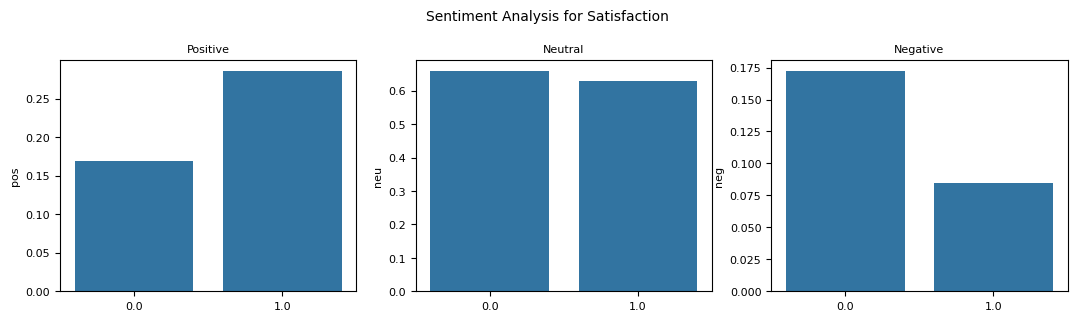

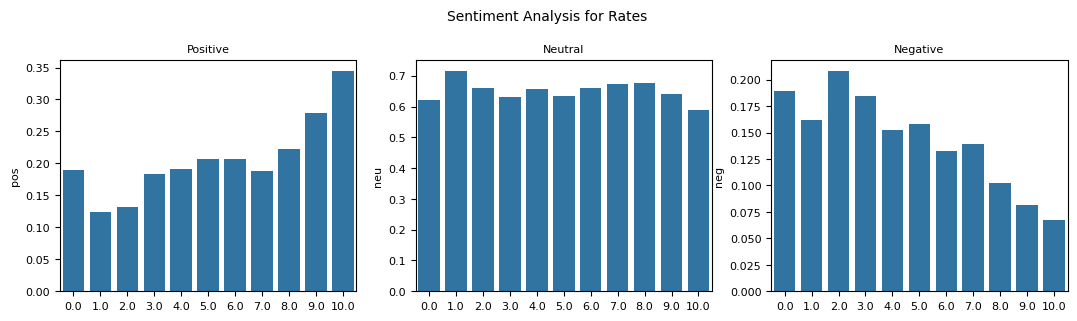

In [99]:
columns = ['pos','neu','neg']

plot_sentiment('Satisfaction', columns, scores_vader)
plot_sentiment('Rates', columns, scores_vader)

### Sentiment Analysis : RoBERTa

In [100]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenize = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def polarity_scores_robert(ex):
        encoded_text = tokenize(ex, return_tensors ='pt') #pt = pytorch
        output = model(**encoded_text) # c'est un tenseur
        scores = output[0][0].detach().numpy() # convertit en array
        scores = softmax(scores)
        scores_dict = {
        'Roberta_neg': round(scores[0].item(), 8),
        'Roberta_neu': round(scores[1].item(), 8),
        'Roberta_pos': round(scores[2].item(), 8)
        }

        return scores_dict

def scoring_roberta(df_analysis):   
    res = {}
    for i, row in tqdm(df_analysis.iterrows(), total = len(df_analysis)):
        try:
            text = row['Feedbacks_clean']
            id = row.name
            roberta_result = polarity_scores_robert(text)
            both = {**roberta_result}
            res[id] = both
        except RuntimeError:
            print(f'Broke for id {id}') #In case tokens over the limit of the model

    scores = pd.DataFrame(res).T
    scores = scores.reset_index(drop=True)
    scores = scores.merge(df_analysis[['Satisfaction']].reset_index(drop=True), how='left', left_index=True, right_index=True)
    scores = scores.merge(df_analysis[['Rates']].reset_index(drop=True), how='left', left_index=True, right_index=True)

    return(scores)

In [101]:
df_analysis.head()

,Rates,Satisfaction,Services_suggestions,Feedbacks,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
2,5.0,0.0,"Just get the basics right first and keep them right. The auto passport readers now work very quickly, this was previously a problem and still is at other airports.",Sort out the airport own parking so it works when you prepay.,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]"
9,10.0,1.0,None at this time,Was a first time thru Edinburgh Airport and was excellent all around service.,was a first time thru edinburgh airport and was excellent all around service,first time thru excellent around service,"[first, time, thru, excellent, around, service]"
15,5.0,1.0,No,The British Airways check in staff were very kind and helpful.,the british airways check in staff were very kind and helpful,british airway check staff kind helpful,"[british, airway, check, staff, kind, helpful]"
16,9.0,1.0,No,There should more easy accesible internet.,there should more easy accesible internet,easy accesible internet,"[easy, accesible, internet]"
17,10.0,1.0,Tour guide for those who have 6 to 8 hrs or staying over night,Gate advisory not less than an hour from departure,gate advisory not less than an hour from departure,gate advisory less hour departure,"[gate, advisory, less, hour, departure]"


In [102]:
scores_roberta = scoring_roberta(df_analysis)
scores_roberta.head()

100%|███████████████████████████████████████| 2114/2114 [01:42<00:00, 20.53it/s]


,Roberta_neg,Roberta_neu,Roberta_pos,Satisfaction,Rates
0,0.049058,0.604657,0.346285,0.0,5.0
1,0.002280,0.032380,0.965341,1.0,10.0
2,0.001708,0.023010,0.975282,1.0,5.0
3,0.058408,0.413308,0.528284,1.0,9.0
4,0.053321,0.904615,0.042064,1.0,10.0


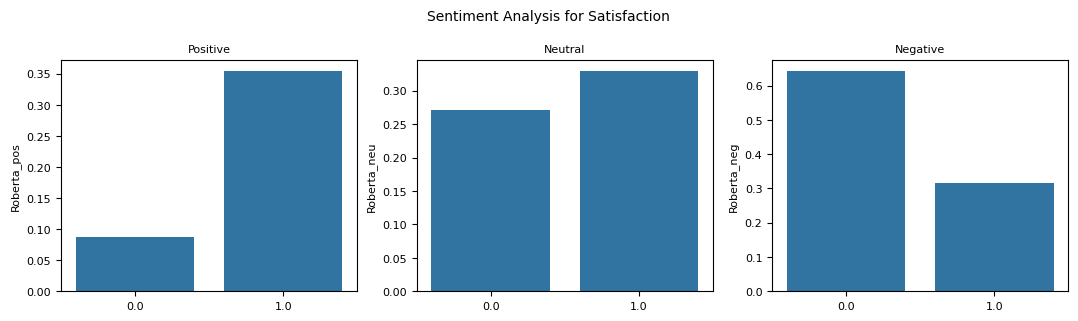

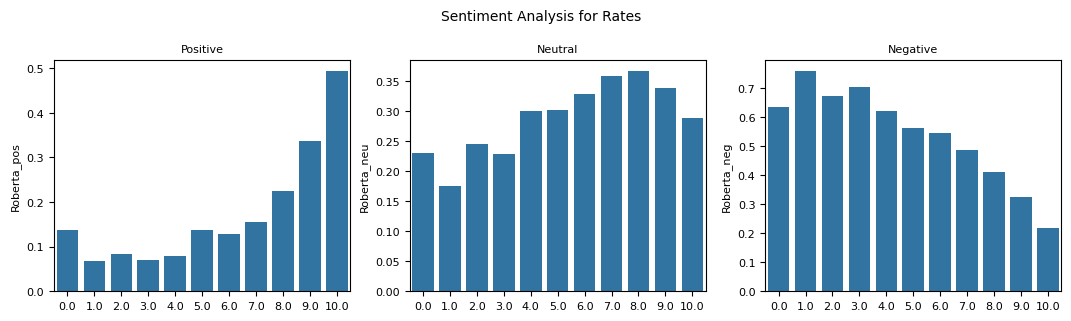

In [103]:
columns = ['Roberta_pos','Roberta_neu','Roberta_neg']

plot_sentiment('Satisfaction', columns, scores_roberta)
plot_sentiment('Rates', columns, scores_roberta)

### Prediction : Satisfaction and Rate

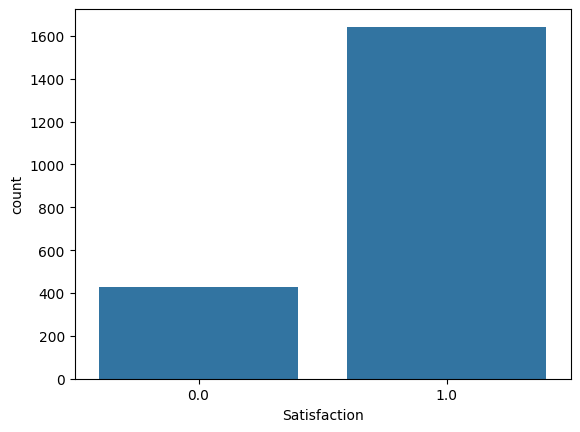

In [21]:
sns.countplot(x='Satisfaction', data = df_analysis)
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler    
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight

TF_IDF=TfidfVectorizer()

### Prediction of satisfaction

In [37]:
def roc_curve_graph(xgb,df_no_na,sampler=None):
    
    X = TF_IDF.fit_transform(df_no_na["Feedbacks_lem"])
    X = pd.DataFrame(X.toarray())
    Y = df_no_na['Satisfaction']

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    if sampler is not None:
        x_train, y_train = sampler.fit_resample(x_train, y_train)
        xgb.fit(x_train, y_train)
    else:
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        xgb.fit(x_train, y_train, sample_weight=sample_weights)

    
    def metrics(x,y):
        
        y_pred = xgb.predict(x)
        y_prob = xgb.predict_proba(x)[:, 1]

        acc = accuracy_score(y_pred,y)
        auc = roc_auc_score(y,y_prob)

        fpr1, tpr1, thresholds = roc_curve(y, y_prob)
        
        return(fpr1, tpr1, acc, auc)

    fpr1,tpr1,training_acc,training_auc = metrics(x_train,y_train)
    fpr2,tpr2,test_acc,test_auc = metrics(x_test,y_test)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    if sampler is not None:
        fig.suptitle(f"Prediction of 'Satisfaction' by {sampler}", fontsize=10)
    else:
        fig.suptitle(f"Prediction of 'Satisfaction' by Sampling Weights", fontsize=10)

    # Courbe ROC pour le train set
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1, tpr1, label=f'AUC = {training_auc:.2f}')
    axes[0].set_title('ROC Curve - Train Set', fontsize = 8)
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].legend()

    # Courbe ROC pour le test set
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].plot(fpr2, tpr2, label=f'AUC = {test_auc:.2f}', color='orange')
    axes[1].set_title('ROC Curve - Test Set', fontsize = 8)
    axes[1].set_xlabel('FPR')
    axes[1].set_ylabel('TPR')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

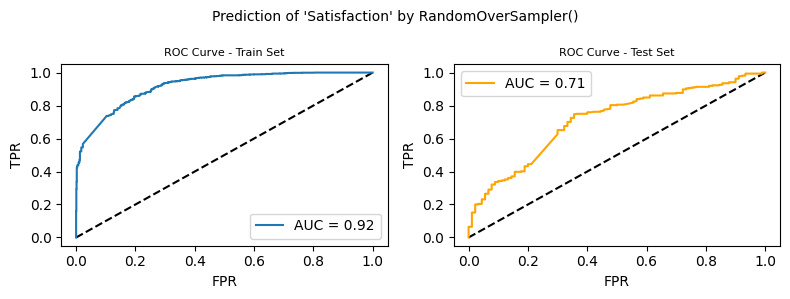

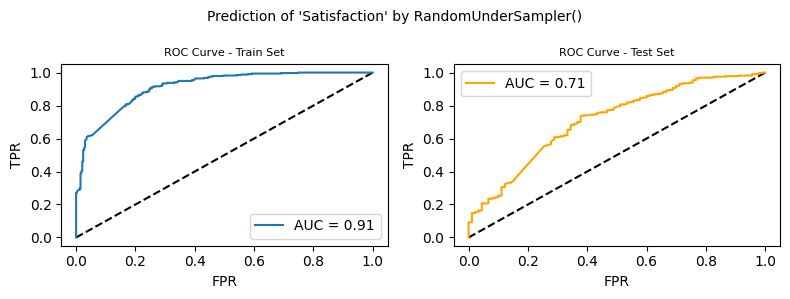

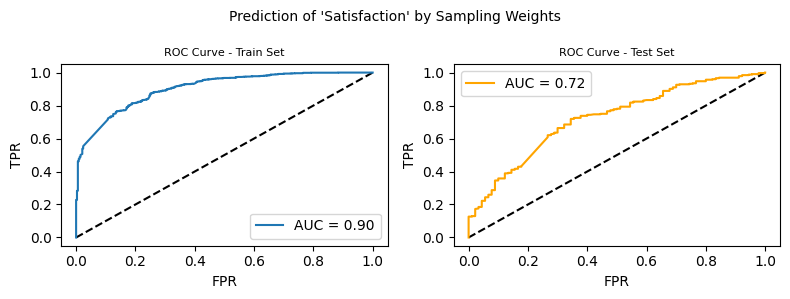

In [63]:
sampler = [RandomUnderSampler(),RandomOverSampler()]
df_no_na = df_analysis.dropna(subset=['Satisfaction']).copy()

xgb = XGBClassifier(n_estimators=1000,learning_rate=0.01,max_depth=3,random_state=24)

roc_curve_graph(xgb,df_no_na,sampler[1])
roc_curve_graph(xgb,df_no_na,sampler[0])
roc_curve_graph(xgb,df_no_na)

### Prediction of rates

In [72]:
from sklearn.decomposition import TruncatedSVD

def rates_metrics(xgb,df_no_na_rates,sampler=None):
    
    X = TF_IDF.fit_transform(df_no_na_rates["Feedbacks_lem"])
    X = pd.DataFrame(X.toarray())
    
    Y = df_no_na_rates['Rates']

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

    #svd = TruncatedSVD(n_components=100, random_state=42)
    #x_train = svd.fit_transform(x_train)
    #x_test = svd.transform(x_test)

    if sampler is not None:
        x_train, y_train = sampler.fit_resample(x_train, y_train)
        xgb.fit(x_train, y_train)
    else:
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        xgb.fit(x_train, y_train, sample_weight=sample_weights)
    
    def metrics(x,y):
        
        y_pred = xgb.predict(x)
        y_prob = xgb.predict_proba(x)

        acc = accuracy_score(y,y_pred,)
        auc = roc_auc_score(y,y_prob, multi_class='ovr', average='macro')
    
        return(acc, auc)

    training_acc,training_auc = metrics(x_train,y_train)
    test_acc,test_auc = metrics(x_test,y_test)

    return(print(f"Sampler : {sampler}\nTRAIN | Accuracy : {training_acc}, AUC : {training_auc}\nTEST  | Accuracy : {test_acc}, AUC : {test_auc}"))

In [67]:
def plot_percent(df,column):

    n_color = df[column].nunique()
    
    plt.figure(figsize=(9, 5))  
    ax = sns.countplot(  
        data=df, 
        x=column,
        #order=df[column].value_counts().index,  
        hue = column,
        palette = sns.color_palette("hls", n_color),
        legend = False
    )
    total = len(df[column].dropna())
    
    for p in ax.patches:
        percentage = 100 * p.get_height() / total
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', 
                    va='center',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=7)
    
    ax.set_title(column, fontsize=8)
    ax.set_xlabel('Responses', fontsize=7)
    ax.set_ylabel('Percents', fontsize=7)  
    plt.xticks(rotation=45, ha='right')
    plt.show()

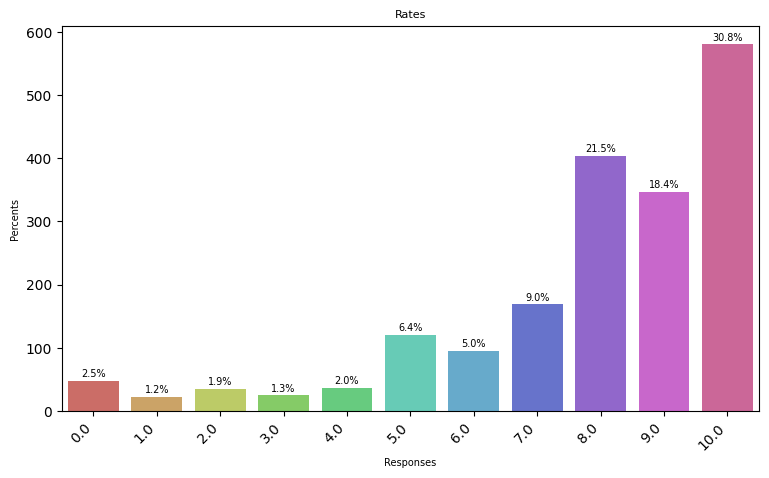

In [68]:
df_no_na_rates = df_analysis.dropna(subset=['Rates']).copy()
plot_percent(df_no_na_rates,'Rates')

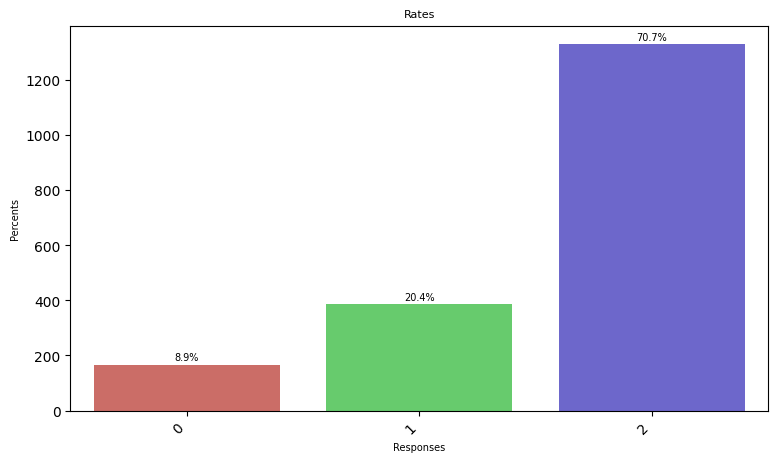

In [69]:
mapping = {
    0.0: 0, 1.0: 0, 2.0: 0, 3.0: 0, 4.0: 0,
    5.0: 1, 6.0: 1, 7.0: 1,                  
    8.0: 2, 9.0: 2, 10.0: 2                  
}

df_fusion = df_analysis.dropna(subset=['Rates']).copy()
df_fusion['Rates'] = df_fusion['Rates'].map(mapping)
plot_percent(df_fusion,'Rates')

In [73]:
xgb = XGBClassifier(n_estimators=1000,learning_rate=0.01,max_depth=3,random_state=24,
                    objective='multi:softprob',
                    num_class=11,
                    eval_metric='mlogloss')

rates_metrics(xgb,df_fusion)
rates_metrics(xgb,df_fusion,sampler[0])
rates_metrics(xgb,df_fusion,sampler[1])

Sampler : None
TRAIN | Accuracy : 0.7682602921646746, AUC : 0.91430249604415
TEST  | Accuracy : 0.5251989389920424, AUC : 0.5945990382755473
Sampler : RandomUnderSampler()
TRAIN | Accuracy : 0.835820895522388, AUC : 0.9543235315957527
TEST  | Accuracy : 0.46684350132625996, AUC : 0.5390876258572889
Sampler : RandomOverSampler()
TRAIN | Accuracy : 0.8295739348370927, AUC : 0.948534547129101
TEST  | Accuracy : 0.5517241379310345, AUC : 0.5956004094474174


In [71]:
# Results not good

### Topic Modeling

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
#df_analysis.head()
#df_analysis.shape

In [50]:
target = 'Feedbacks_lem'

tfidf = vectorizer.fit_transform(df_analysis[target])

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(tfidf)
terms = vectorizer.get_feature_names_out()

In [51]:
for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[::-1][:5]
    top_terms = [terms[ind] for ind in top_indices]
    print(f"Topic {i}: {' | '.join(top_terms)}")

Topic 0: security | staff | would | time | gate
Topic 1: area | drop | charge | charging | smoking
Topic 2: toilet | clean | seat | comfortable | seating
